In this notebook we are going to show how one could construct a 2D free energy surface from the results of umbrella sampling that was only biased in 1D, i.e. along a single CV. Such 'deprojection' will be used/applied to extract the internal energy U(CV) contribution to the original free energy profile F(CV).

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import BaseFreeEnergyProfile, SimpleFreeEnergyProfile, FreeEnergySurface2D, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D, Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader, ASEExtendedXYZReader
from thermolib.thermodynamics.condprob import ConditionalProbability, ConditionalProbability1D1D
from thermolib.thermodynamics.cv import CoordinationNumber, LinearCombination

import numpy as np, matplotlib.pyplot as pp, os

import matplotlib.pyplot as pp
import matplotlib.cm as cm
from matplotlib import gridspec, rc
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from molmod.units import *

In [3]:
prefix = 'advanced_wham1D_to_2D_'
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'

# 1D FEP in terms of CV

We first construct the original 1D FEP by means of a regular WHAM analysis.

In [4]:
colvar_reader = ColVarReader([0], units=['au'], end=10000)
temp, bias1d, traj1d = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    verbose=True,
)

Temperature set at 273.000000
Added bias Parabola1D (u0): K=3500 kjmol  q0=-1.500e+00 au
Added bias Parabola1D (u1): K=3500 kjmol  q0=-1.476e+00 au
Added bias Parabola1D (u2): K=3500 kjmol  q0=-1.453e+00 au
Added bias Parabola1D (u3): K=3500 kjmol  q0=-1.429e+00 au
Added bias Parabola1D (u4): K=3500 kjmol  q0=-1.406e+00 au
Added bias Parabola1D (u5): K=3500 kjmol  q0=-1.382e+00 au
Added bias Parabola1D (u6): K=3500 kjmol  q0=-1.358e+00 au
Added bias Parabola1D (u7): K=3500 kjmol  q0=-1.335e+00 au
Added bias Parabola1D (u8): K=3500 kjmol  q0=-1.311e+00 au
Added bias Parabola1D (u9): K=3500 kjmol  q0=-1.287e+00 au
Added bias Parabola1D (u10): K=3500 kjmol  q0=-1.264e+00 au
Added bias Parabola1D (u11): K=3500 kjmol  q0=-1.240e+00 au
Added bias Parabola1D (u12): K=3500 kjmol  q0=-1.217e+00 au
Added bias Parabola1D (u13): K=3500 kjmol  q0=-1.193e+00 au
Added bias Parabola1D (u14): K=3500 kjmol  q0=-1.169e+00 au
Added bias Parabola1D (u15): K=3500 kjmol  q0=-1.146e+00 au
Added bias Parabola1

We compute the correlation time between samples of the CV for each trajectory based on the auto correlation function.

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

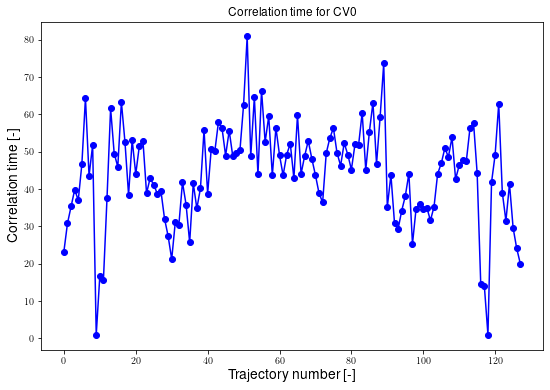

In [5]:
corrtimes_1d = decorrelate(traj1d, plot=True)

Do 1D-WHAM to extract the probability histogram.

In [6]:
bins = np.arange(-1.55, 1.55, 0.05)
hist1d = Histogram1D.from_wham(bins, traj1d, bias1d, temp, error_estimate='mle_f_cov', corrtimes=corrtimes_1d, cv_label='CV', verbosity='medium', convergence=1e-8, Nscf=20000)

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
SCF Converged!
Estimating error ...
  defining zero-mask ...
    deactivated 0 bins
    deactivated 0 sims
  applying zero-mask ...
  inverting Fisher matrix ...
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.001s
  histograms  : 00h 00m 00.077s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.879s
  error est.  : 00h 00m 00.025s
  TOTAL       : 00h 00m 00.990s
---------------------------------------------------------------------


Convert probability histogram to free energy profile. Detect reaction, transition and product states, set the energy reference such that the reactant microstate is at zero energy and plot the results.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


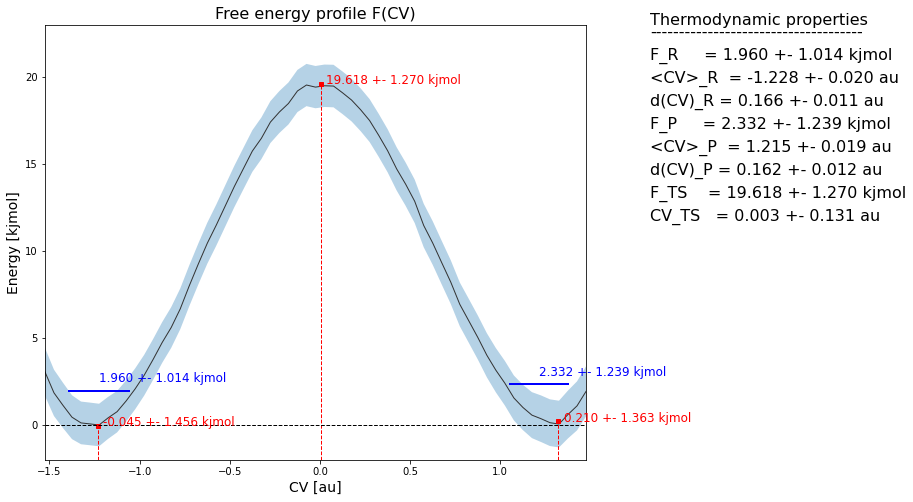

In [7]:
fep = SimpleFreeEnergyProfile.from_histogram(hist1d, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep.set_ref(ref='r')
fep.plot(flims=[-2,23])

We also plot the correlation matrix between points on the free energy profile to illustrate the error bars are correlated. We will also reconstruct this graph later after projecting the deprojected 2D-FES back the the 1D-FEP and compare with the result below.

<Figure size 432x288 with 0 Axes>

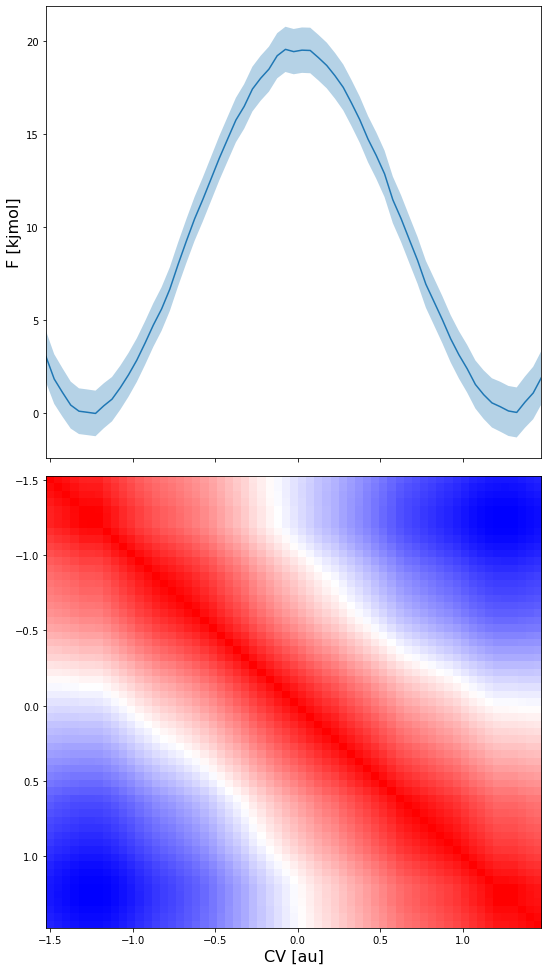

In [8]:
fep.plot_corr_matrix()

# 2D FES in terms of CV and U (internal energy)

In this section, we will construct a 2D free energy surface using the original 1D-biased umbrella simulations using WHAM. The 2D FES is expressed in terms of the original CV and a new additional CV chosen as the potential energy of the total system. This particular choice will later allow to compute the average energy (and its error) as function of the original CV. This in turn allows to interpret the original 1D FEP in terms of its energy and entropy contributions.

Computing the 2D FES can be done in two different ways, which we will both illustrate here and show that they lead to consistent results. The first, more direct, route applies a 2D WHAM analysis in which the applied biases are invariant under the second CV (which is the internal energy). The second route starts from the original 1D FEP and applies a deprojection using the conditional probability distribution of the new CV (i.e. the internal energy) conditional on the old CV.

## Direct route - 2D WHAM

In [9]:
colvar_reader = ColVarReader([0], units=['au'], end=10000)
extxyz_reader = ASEExtendedXYZReader(['energy'], units=['electronvolt'], reload=True)
temp, bias2d, traj2d = read_wham_input(fn_meta, [colvar_reader,extxyz_reader], ['colvars/COLVAR_%s.dat','colvars/%s.xyz'], kappa1_unit='kjmol', q01_unit='au', bias_potential='Parabola2D', verbose=True)

Temperature set at 273.000000
Added bias Parabola2D (u0): K1=3500 kjmol  q01=-1.500e+00 au  K2=0 kjmol  q02=0.000e+00 au The 1D bias was redefined in 2D, the force constant in the second CV was set to zero.
Added bias Parabola2D (u1): K1=3500 kjmol  q01=-1.476e+00 au  K2=0 kjmol  q02=0.000e+00 au The 1D bias was redefined in 2D, the force constant in the second CV was set to zero.
Added bias Parabola2D (u2): K1=3500 kjmol  q01=-1.453e+00 au  K2=0 kjmol  q02=0.000e+00 au The 1D bias was redefined in 2D, the force constant in the second CV was set to zero.
Added bias Parabola2D (u3): K1=3500 kjmol  q01=-1.429e+00 au  K2=0 kjmol  q02=0.000e+00 au The 1D bias was redefined in 2D, the force constant in the second CV was set to zero.
Added bias Parabola2D (u4): K1=3500 kjmol  q01=-1.406e+00 au  K2=0 kjmol  q02=0.000e+00 au The 1D bias was redefined in 2D, the force constant in the second CV was set to zero.
Added bias Parabola2D (u5): K1=3500 kjmol  q01=-1.382e+00 au  K2=0 kjmol  q02=0.000e+

In order to obtain a convenient range of energies, the energy values along the trajectory are re-referenced so that the minimum of all means of the simulation is zero.

In [10]:
ref = None
for data in traj2d:
    if ref is None:
        ref = data[:,1].mean()
    else:
        ref = min(ref, data[:,1].mean())
for data in traj2d:
    data[:,1] -= ref

Next we again decorrate data. In principle, we need to take into account the maximum of the correlation times of both CVs, but for the sake of investigating the impact, we will decorrelate in two fashions:
1) only decorrelate according to the first (original) CV, denoted with suffix `_decor1`
2) decorrelate according to both CVs, denoted with suffix `_decor2`

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

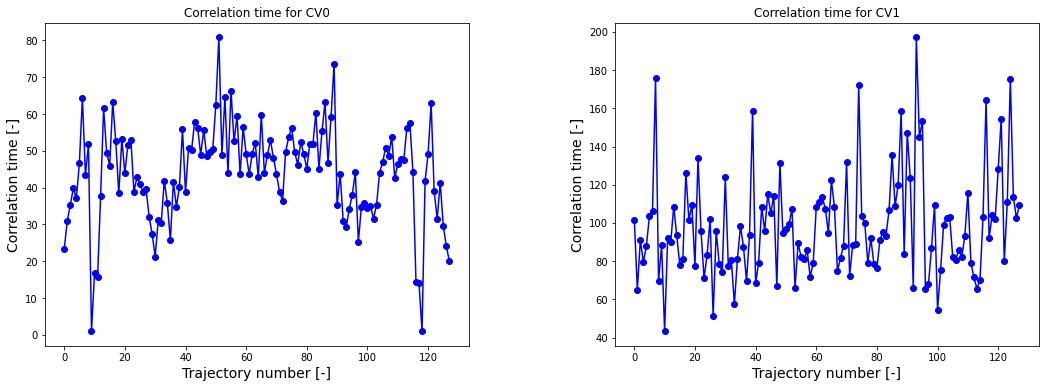

In [11]:
corrtimes_2d = decorrelate(traj2d, plot=True)

We take a brief look at the typical range of internal energies to have an idea how to bin our energy samples.

In [12]:
lower, upper = np.inf, -np.inf
for data in traj2d:
    es = data[:,1]/kjmol
    lower = min(lower, es.mean()-3*es.std())
    upper = max(upper, es.mean()+3*es.std())
print(lower,upper)

-32.31289121089313 50.24649344792951


Based on this range, we bin the energy within [-25,50] kjmol.

In [13]:
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-25, 52.5, 2.5)*kjmol

hist2d1 = Histogram2D.from_wham([bins_cv, bins_u], traj2d, bias2d, temp, error_estimate='mle_f_cov', error_p_threshold=0.001, corrtimes=corrtimes_2d, convergence=1e-7, Nscf=50000, cv2_output_unit='kjmol', cv1_label='CV', cv2_label='U', verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
  SCF Converged!
Estimating error ...
  defining zero-mask ...
    deactivated 649 bins
    deactivated 0 sims
  applying zero-mask ...
  inverting Fisher matrix ...

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.077s
  bias poten. : 00h 00m 01.202s
  solve scf   : 00h 00m 06.079s
  error est.  : 00h 00m 02.695s
  TOTAL       : 00h 00m 10.055s
---------------------------------------------------------------------


In [14]:
fes1 = FreeEnergySurface2D.from_histogram(hist2d1, temp)
fes1.set_ref(ref='min')

Let us now make some 2D contour plots as well as 1D intersection plots of the FES.

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1644: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

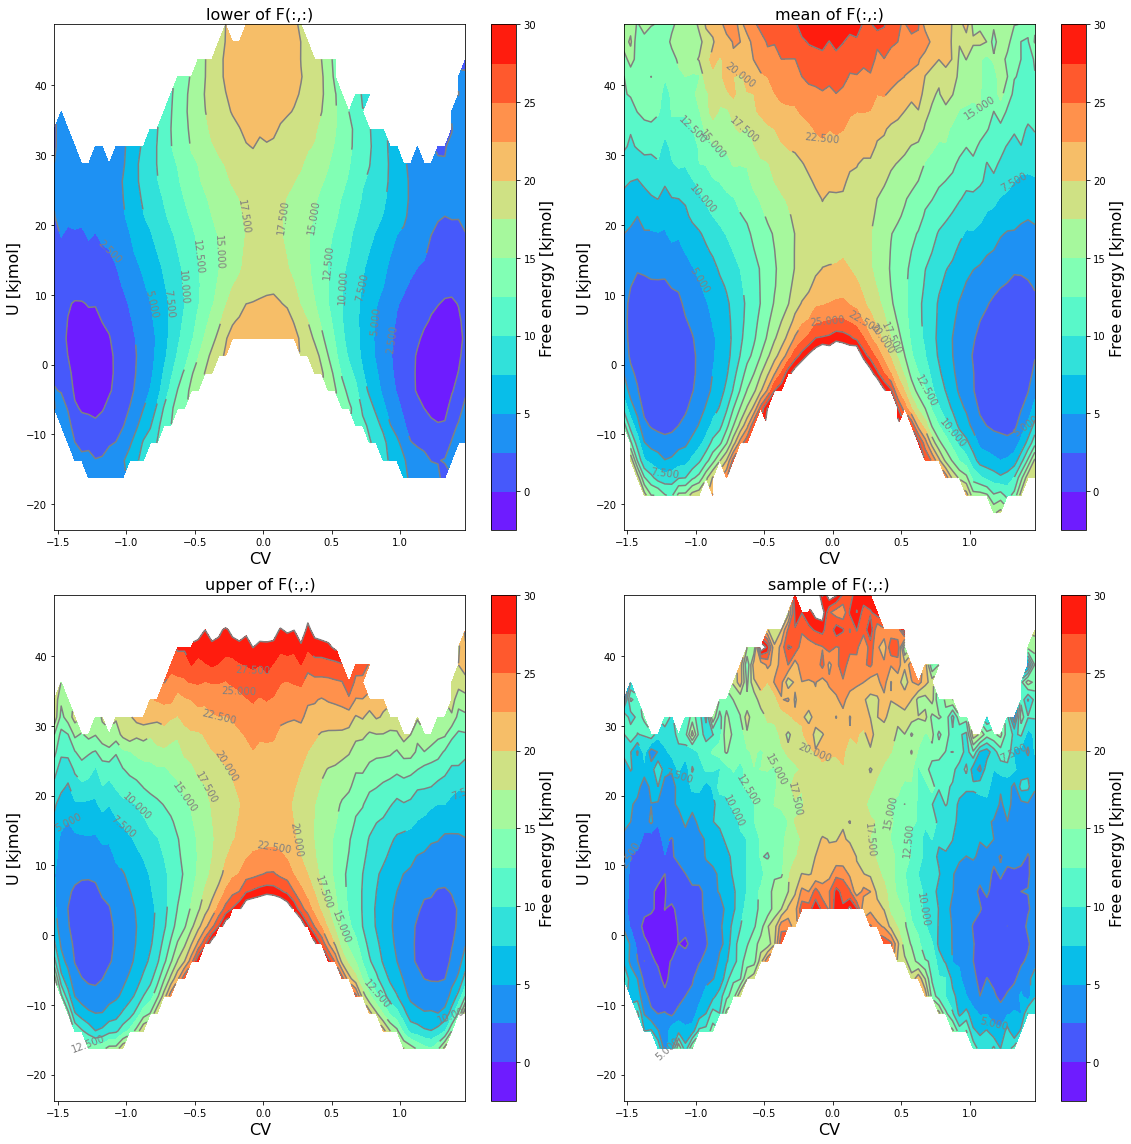

In [15]:
fes1.plot(obss=['lower', 'mean', 'upper', 'sample'], flims=[-2.5,30], ncolors=13, cmap='rainbow')

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning

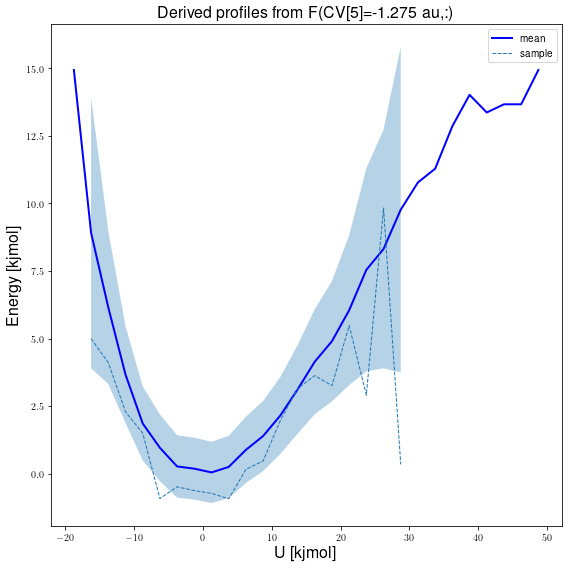

In [17]:
fes1.plot(slicer=[5,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning

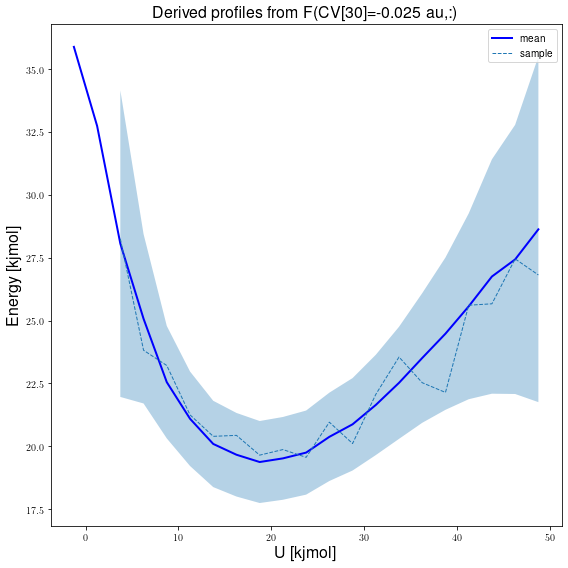

In [18]:
fes1.plot(slicer=[30,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning

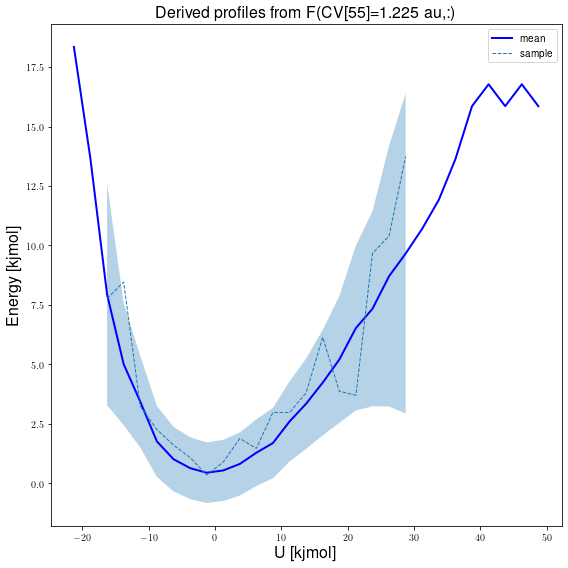

In [19]:
fes1.plot(slicer=[55,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning

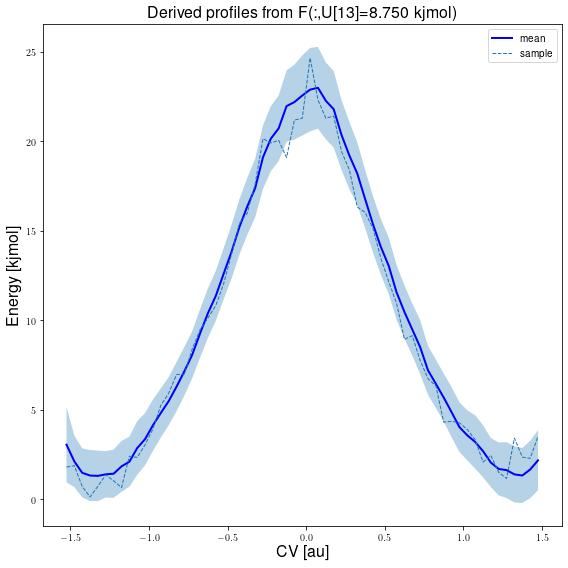

In [20]:
fes1.plot(slicer=[slice(None),13], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning

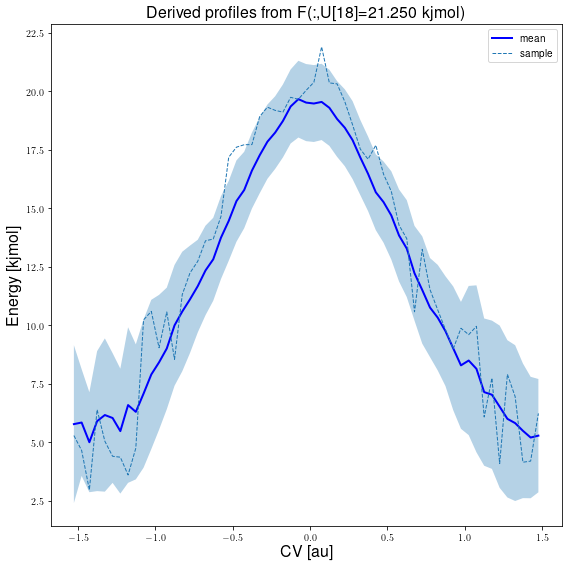

In [21]:
fes1.plot(slicer=[slice(None),18], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

## Indirect route - deproject 1D FEP

In the indirect route, we start from the 1D FEP F(CV) and extract the 2D FES F(CV,U) by means of the following deprojection formula that can be easily derived from Bayes theorem from probability theory applied to the corresponding probability histograms:

\begin{align}
    P(CV,U) &= P(U|CV)\cdot P(CV) \\
    F(CV,U) &= -k_B T \log\left(P(CV,U)\right) = F(CV) -k_BT \log\left(P(U|CV)\right)
\end{align}

in which $P(CV,U)=e^{-\beta F(CV,U)}$ is the 2D probability histogram related to the desired 2D FES, $P(U|CV)$ is the conditional probability we will need to construct from simulations and $P(CV)=e^{-\beta F(CV)}$ is the original 1D probability histogram related to the original 1D FEP.

In [22]:
#initialize conditional probability
condprob = ConditionalProbability1D1D(q_output_unit='kjmol', cv_output_unit='au', q_label='U')

#initialize TrajectoryReaders to extract CV and Q values from trajectory files
root = os.path.dirname(fn_meta)
cv_reader = ColVarReader([0], units=['au'], name='CV', end=10000)
u_reader = ASEExtendedXYZReader(['energy'], units=['electronvolt'], name='U', reload=True)

#Read trajectory files and construct conditional probability
for i in range(128):
    condprob.process_simulation(
        [('%s/colvars/u%i.xyz'        %(root,i), u_reader )], 
        [('%s/colvars/COLVAR_u%i.dat' %(root,i), cv_reader)], 
        finish=False, corr_time=corrtimes_2d[i]
    )

In [23]:
#set reference value to minimum of the q-average of each simulation
condprob.set_ref(q_index='all', q_ref='minimum_average')

In [24]:
#finish conditional probability using the specified bin range for U and CV
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-25, 52.5, 2.5)*kjmol
condprob._finished = False
condprob.finish([bins_u], [bins_cv], error_estimate='mle_f_cov', error_p_threshold=0.001)

Before continuing, let's make some plots of the conditional probability, both 2D contour plots as well as 1D intersection plots

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/condprob.py:407: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xs = self.error.nsigma_conf_int(2)[0][slicer]
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/condprob.py:401: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xs = self.pconds[slicer].copy()
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/condprob.py:410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr

<Figure size 432x288 with 0 Axes>

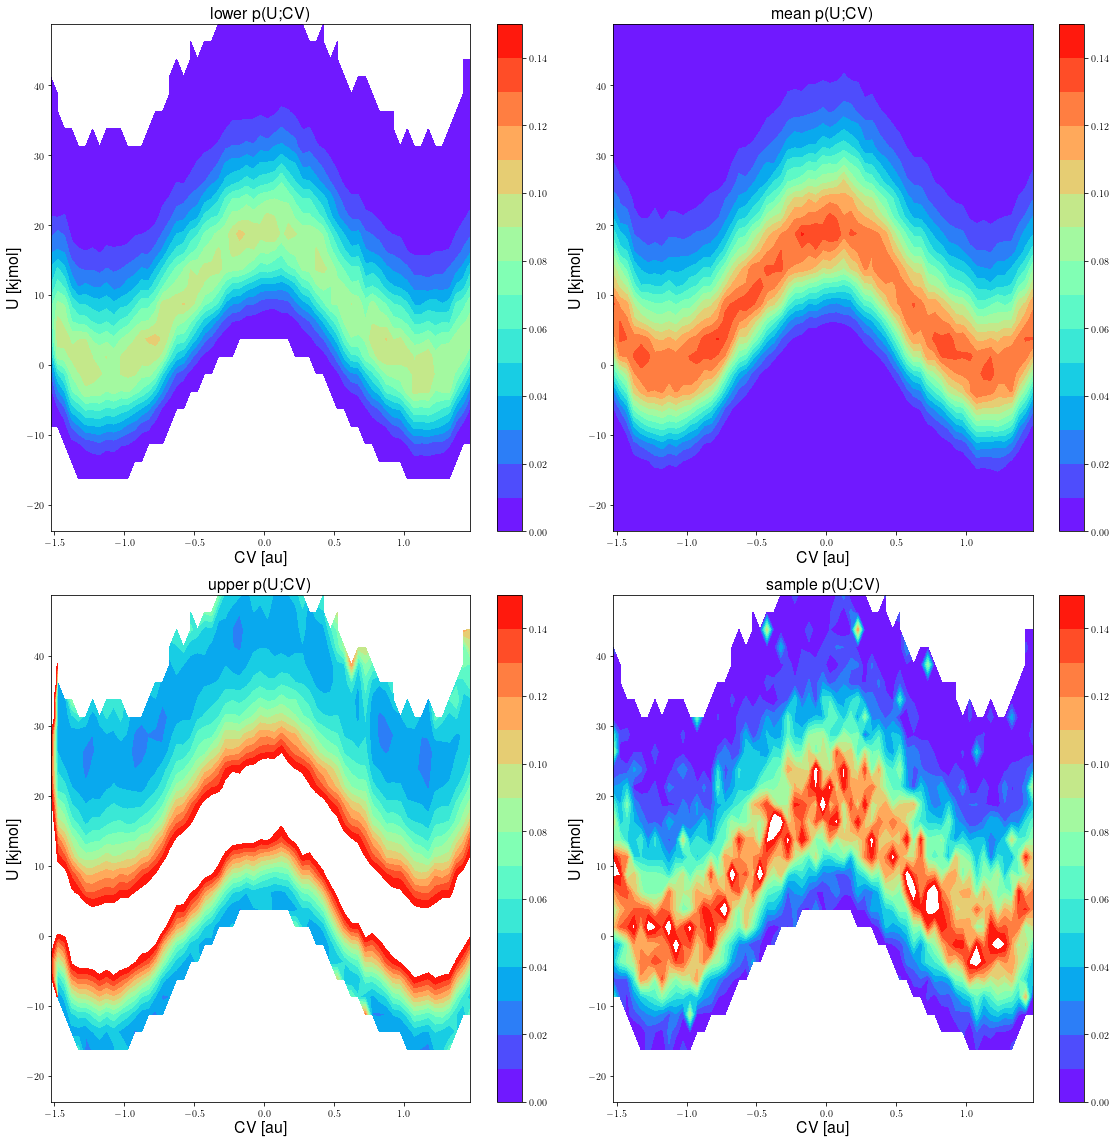

In [29]:
condprob.plot(slicer=[slice(None),slice(None)], obss=['lower', 'mean', 'upper', 'sample'], cmap='rainbow', levels=np.linspace(0.0,0.15,16))

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/condprob.py:431: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lower, upper = lower[slicer], upper[slicer]


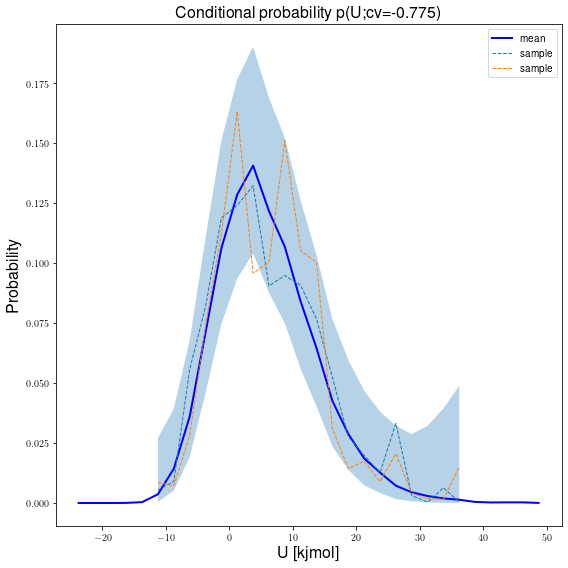

In [30]:
condprob.plot([15,slice(None)], obss=['mean', 'sample', 'sample'], linewidths=[2,1,1], linestyles=['-','--','--'], colors=['b',None,None])

In [31]:
fes2 = condprob.deproject(fep, cv_output_unit='au', q_output_unit='kjmol', cv_label='CV', q_label='U')
fes2.set_ref(ref='min')

Error propagation - generating argument samples...
  ... for argument 0 (=MultiGaussianDistribution)
  ..... resulted in argsamples[0].shape= (61, 50)
  ... for argument 1 (=ErrorArray)
  ..... resulted in argsamples[1].shape= (61, 30, 50)
Error propagation - calculating function values for 50 cycles...
  ... for cycle 0
  ..... function has 2 arguments
  ..... argument 0 has shape: (61,)
  ..... argument 1 has shape: (61, 30)
  ... for cycle 1
  ..... function has 2 arguments
  ..... argument 0 has shape: (61,)
  ..... argument 1 has shape: (61, 30)
  ... for cycle 2
  ..... function has 2 arguments
  ..... argument 0 has shape: (61,)
  ..... argument 1 has shape: (61, 30)
  ... for cycle 3
  ..... function has 2 arguments
  ..... argument 0 has shape: (61,)
  ..... argument 1 has shape: (61, 30)
  ... for cycle 4
  ..... function has 2 arguments
  ..... argument 0 has shape: (61,)
  ..... argument 1 has shape: (61, 30)
  ... for cycle 5
  ..... function has 2 arguments
  ..... argume

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1578: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1575: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert self.error is not None, 'Observable %s can only be plotted if error is defined!' %obs
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1581:

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1589: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  assert ndim==len(values.shape), 'Observable data has inconsistent dimensions!'
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1646: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  pp.clabel(contour, inline=1, fontsize=10)


<Figure size 432x288 with 0 Axes>

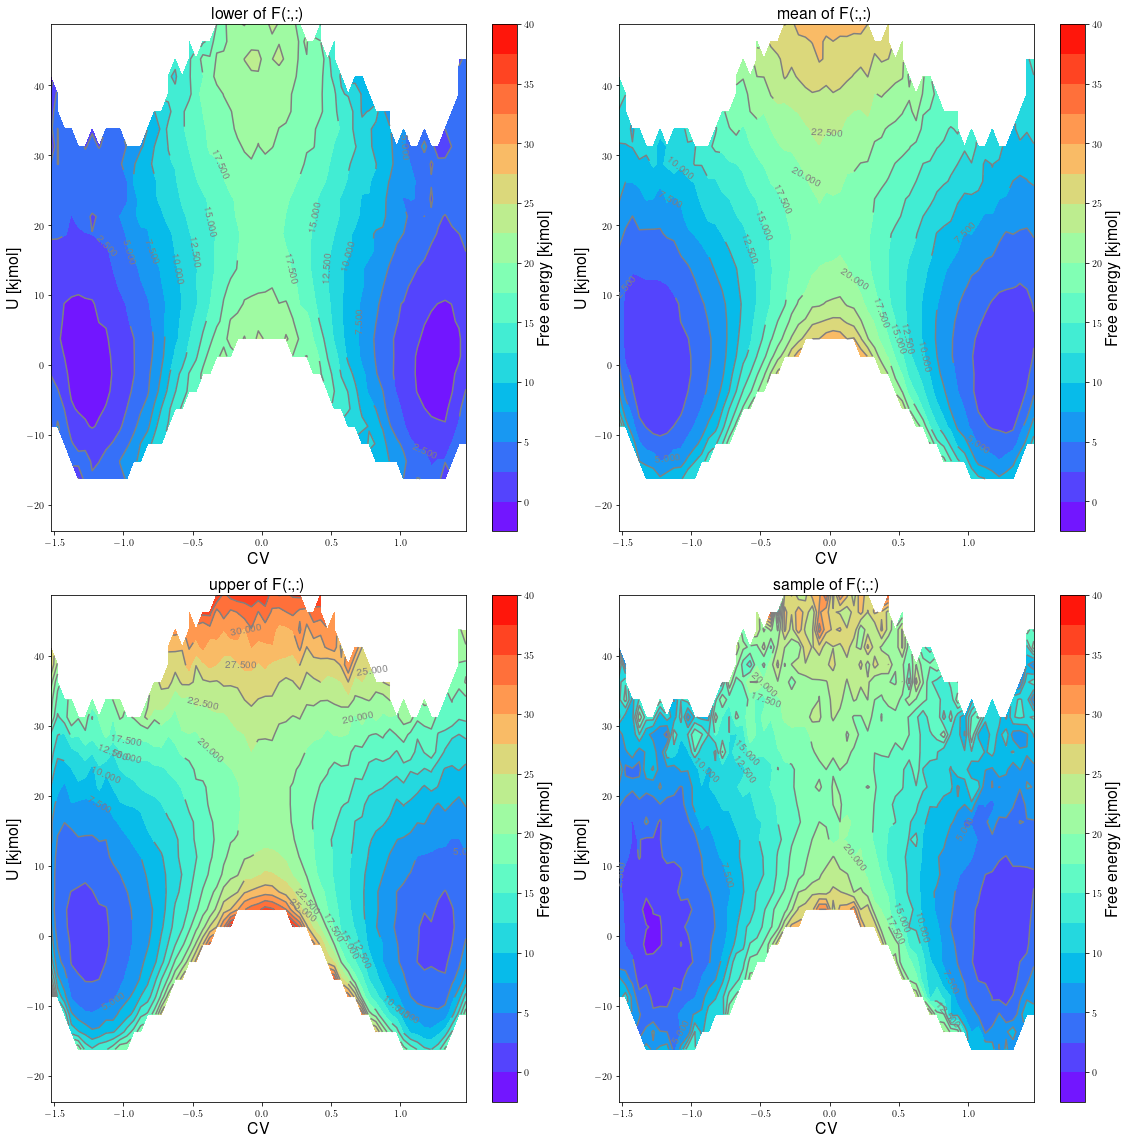

In [32]:
fes2.plot(obss=['lower', 'mean', 'upper', 'sample'], flims=[-2.5,40], ncolors=17, cmap='rainbow')

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  linestyles = [None,]*len(data)


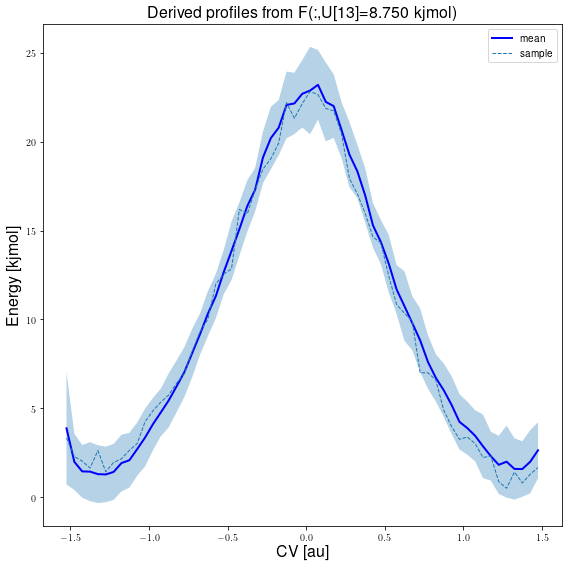

In [33]:
fes2.plot(slicer=[slice(None),13], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

This looks indeed as essentially the same 2D FES as before, except for a shift in the U values due to slightly different reference that was applied.

## CONSISTENCY CHECK: project 2D FES to 1D FEP

As a consistency check, we project the newly constructed 2D FES in terms of CV and U back towards a 1D FEP in terms of CV and compare the results with the original 1D FEP, these should be the same.

In [34]:
fep_from_fes1 = fes1.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_from_fes1.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep_from_fes1.set_ref(ref='r')

In [35]:
fep_from_fes2 = fes2.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_from_fes2.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep_from_fes2.set_ref(ref='r')

<Figure size 432x288 with 0 Axes>

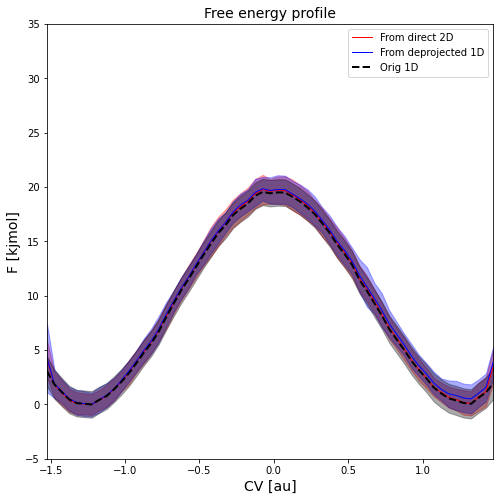

In [36]:
plot_profiles([fep_from_fes1,fep_from_fes2,fep], labels=['From direct 2D','From deprojected 1D','Orig 1D'], colors=['r','b','k'], linestyles=['-','-','--'], linewidths=[1,1,2], flims=[-5,35])

As can be seen, both the direct and indirect methods for computing the 2D FES give rise, upon projecting back on the original CV, to the same 1D profile as the original 1D FEP including its error bar! Below, we also consider the correlations between free energy of different points of the 1D FEP and that is also consistent with the orginal 1D WHAM result!

<Figure size 432x288 with 0 Axes>

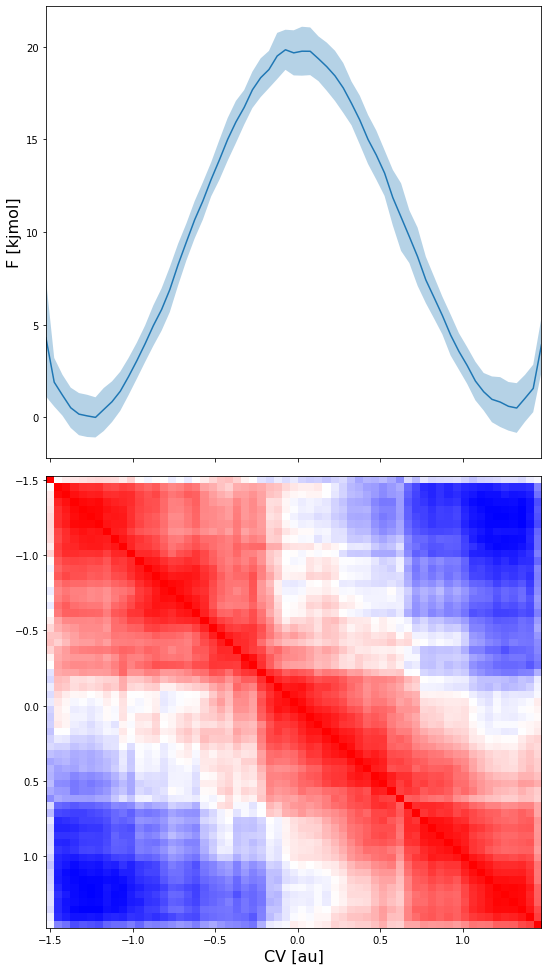

In [37]:
fep_from_fes2.plot_corr_matrix()

# U(CV) profile

In this section, we will construct the internal energy contribution to the previously determined Free energy profile. This can again be done in one of two fashions, either by starting from the 2D FES $F(CV,U)$ or by starting from the conditional probability $P(U|CV)$

## method 1 - from 2D FES

In this first method, we compute the average energy as function of the origal CV from the 2D histogram using the routine ``average_cv_constraint_other``, in which we compute the average of one CV (in this case the internal energy U) while constraining the other (in this case the original CV). For this method, we can use either one of the two previously illustrated method to construct the 2D FES, as they were identical. We choose to use the FES resulting from the direct method, i.e. ``fes2d1`` and corresponding histogram ``hist2d1``.

In [38]:
#compute profile of Us using the histogram hist2 (which encodes probability p(cv,u)) as the average of U (second independent variable in p(cv,u)) as function of CV (first indepedent variable in p(cv,u)):
U_from2d = hist2d1.average_cv_constraint_other(2)
U_from2d.set_ref(ref='min')

## method 2 - from conditional probability

In the second method, we use the conditional probability directly to again compute the average energy as function of the origal CV using the routine ``average``.

In [39]:
U_fromcond = condprob.average()
U_fromcond.set_ref(ref='min')

## comparison

<Figure size 432x288 with 0 Axes>

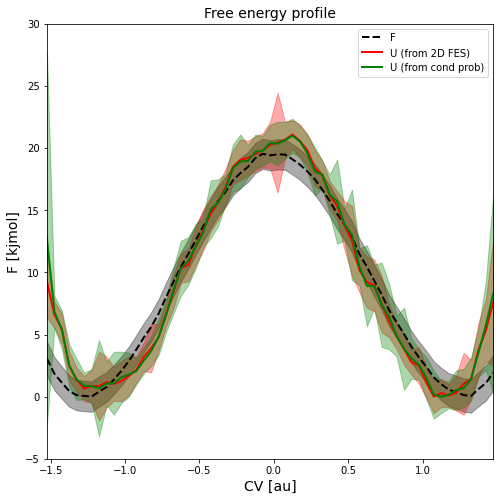

In [40]:
plot_profiles([fep, U_from2d, U_fromcond], labels=['F','U (from 2D FES)', 'U (from cond prob)'], colors=['k', 'r', 'g'], linestyles=['--','-', '-'], flims=[-5,30])

As we can see, the two methods give the same results, only there error bars differ. In this respect, the method using the conditional probability seems to give rise to slightly higher error bars.